<a href="https://www.kaggle.com/code/youssefashraf7/mlproject?scriptVersionId=134631827" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Importing libraries**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import os
import cv2
from PIL import Image,ImageOps
warnings.filterwarnings('ignore')
import random as rnd
import keras_tuner
from keras.utils import to_categorical

import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers

# **Reading the pictures**

Reading : /kaggle/input/30k-cats-and-dogs-150x150-greyscale/Animal Images/cats
Reading : /kaggle/input/30k-cats-and-dogs-150x150-greyscale/Animal Images/dogs


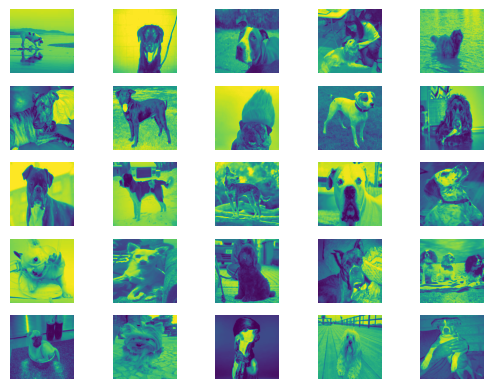

In [2]:
# define a list of dictionaries where each dictionary contains the path to a folder and an empty array
folder_paths = [{"path":"/kaggle/input/30k-cats-and-dogs-150x150-greyscale/Animal Images/cats","arr":[]},
                {"path":"/kaggle/input/30k-cats-and-dogs-150x150-greyscale/Animal Images/dogs","arr":[]}]

# Define the number of samples to use from each class
sample_size=10000

photos = []
labels = []

#The image load process
for folder in folder_paths:
    print("Reading :", folder["path"])
    for cnt,filename in enumerate(os.listdir(folder["path"])):
        
        if cnt < sample_size:
            if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
                img = ImageOps.grayscale(Image.open(os.path.join(folder["path"], filename)))
                img = img.resize((150,150))

                #Display some images for first look
                if cnt < 25:  
                    plt.subplot(5,5,cnt+1)
                    plt.imshow(img)
                    plt.axis("off")

                labels.append(folder["path"].split("/")[-1])
                photos.append(np.array(img))

# **Getting the data ready**

In [4]:
labels = [0 if x == "cats" else 1 for x in labels]
labels = to_categorical(labels, dtype ="uint8")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(photos, labels, test_size=0.3, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [6]:
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("Y_train shape:",y_train.shape)
print("Y_test shape:",y_test.shape)

X_train shape: (13999, 22500)
X_test shape: (6000, 22500)
Y_train shape: (13999, 2)
Y_test shape: (6000, 2)


# **NN Model (baseline model)**

In [7]:
epochs_num = 20
batch_size = 5

baseline_model = Sequential()

baseline_model.add(Dense(16, input_shape=X_train.shape[1:], activation='relu'))
baseline_model.add(Dropout(0.25))
baseline_model.add(Dense(8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
baseline_model.add(Dropout(0.25))
baseline_model.add(Dense(2, activation='softmax'))
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                360016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 360,170
Trainable params: 360,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
baseline_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Training the model
epochs_num = 10
batch_size = 260

baseline_model.fit(X_train, y_train, epochs=epochs_num, batch_size=batch_size)

In [ ]:
#evaluting the model
y_pred = baseline_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print("NN accuracy : ", (round(accuracy_score(y_test, y_pred), 3)) * 100, "%")

In [ ]:
baseline_precision = precision_score(y_test, y_pred)
baseline_recall = recall_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)

print("Precision score = ", round(baseline_precision, 3))
print("Recall score = ", round(baseline_precision, 3))
print("F1 score = ", round(baseline_f1, 3))

# **CNN Model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(photos, labels, test_size=0.3, random_state=42)

X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

X_train = X_train.reshape(-1,X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(-1,X_test.shape[1],X_test.shape[2],1)

In [ ]:
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("Y_train shape:",y_train.shape)
print("Y_test shape:",y_test.shape)

In [ ]:
#defining model
model = Sequential()

#adding convolution layer
model.add(Conv2D(filters = 12, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = X_train.shape[1:]))

#adding pooling layer
model.add(MaxPool2D(pool_size=(2,2)))

#another convolution layer
model.add(Conv2D(filters = 24, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

#adding fully connected layer
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1], activation = "sigmoid"))
model.summary()

In [ ]:
#compiling the model
optimizer = Adam(lr=0.001)
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

In [ ]:
#Training the model
epochs = 10
batch_size = 500

model.fit(X_train,y_train,batch_size,epochs)

In [ ]:
#evaluting the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print("CNN accuracy : ", (round(accuracy_score(y_test, y_pred), 3)) * 100, "%")

In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision score = ", round(precision, 3))
print("Recall score = ", round(recall, 3))
print("F1 score = ", round(f1, 3))

In [ ]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print("True negative : " , confusionMatrix[0][0])
print("False negative : " , confusionMatrix[0][1])
print("True positive : " , confusionMatrix[1][1])
print("False positive : " , confusionMatrix[1][0])

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)
disp.plot()
plt.show()

# **Testing**

In [ ]:
import random

counter = 1
fig = plt.figure(figsize=(10, 7))
for folder in folder_paths:
    files = list(enumerate(os.listdir(folder["path"])))
    files = random.sample(files, 4)
    for file in files:
        cnt = file[0]
        filename = file[1]
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
            img = ImageOps.grayscale(Image.open(os.path.join(folder["path"], filename)))
            img = img.resize((150,150))

            img_arr = np.array(img) / 255.0
            
            img_arr = img_arr.reshape(-1,img_arr.shape[0],img_arr.shape[1],1)
            prediction = model.predict(img_arr)
            prediction = np.argmax(prediction, axis=1)

            img_arr = img_arr.reshape(img_arr.shape[0], img_arr.shape[1]*img_arr.shape[2])
            baseline_prediction = baseline_model.predict(img_arr)
            baseline_prediction = np.argmax(baseline_prediction, axis=1)
            
            prediction_label = "dog" if prediction == 1 else "cat"
            baseline_prediction_label = "dog" if baseline_prediction == 1 else "cat"
            
            true_label = "cat" if folder["path"].split("/")[-1] == "cats" else "dog"

            fig.add_subplot(2, 4, counter)
            plt.imshow(img)
            plt.axis('off')
            plt.title("NN : " + baseline_prediction_label + ", CNN : " + prediction_label + ",\ntrue : " + true_label)
            
            counter += 1